# Introduction

The aim of the paper "MIMIC-Extract: A Data Extraction, Preprocessing and Representation Pipeline for MIMIC-III" (S. Wang, M. B. A. McDermott, G. Chauhan, M. Ghassemi, M. C. Hughes, and T. Naumann, 2020) [1] is to provide a standardized processing framework to transform data from MIMIC-III database [2] into data structures that can be directly used in clinically-relevant prediction models.

Benefits of the standardized extraction pipeline are:
*   transform raw data into static and time-series dataframes that researchers can direclty use and focus on answering their research questions instead of spending efforts on data extraction.
*   solve the problem of often-noisy clinical data by unit standardization, outlier handling and clinical aggregation of semantically similar features
*   flexibility in cohort and variable selection with simply changing the variables instead of modifying the source code, thus making it easier to run repeated experiments with ease.




# Scope of reporoducibility

We will preprocess the raw data tables extracted from the MIMIC-III dataset  employing the default cohort selection parameters established in the original publication. This preprocessing aims to yield refined static demographic information of the designated patients, alongside temporally arranged vital signs and laboratory findings.

The original study relied on a locally deployed Postgresql database and Python framework, a resource-intensive setup. According to the authors, a single execution on a machine equipped with 50GB RAM demanded more than 10 days to complete. To mitigate such computational demands and facilitate experimentation with varied cohort compositions and variable selection criteria suitable for diverse research inquiries, we intend to leverage Google Cloud Platform (GCP) for hosting the data and harness the processing capabilities of Google BigQuery.

Consequently, we anticipate generating four distinct pandas dataframes: "patients" containing static demographic attributes, "vital_lab" encapsulating mean values, standard deviations, and counts of time-series vital signs and laboratory outcomes, "vitals_lab_mean" comprising mean values of time-series vital signs and laboratory results, and "interventions" documenting time-series medical and mechanical interventions. These dataframes will be derived using default parameters to facilitate comparison with the outcomes reported in the original publication.

Furthermore, in the final report, we shall illustrate the versatility of the established pipeline by fine-tuning a rudimentary classification model on the extracted data, thereby highlighting the pipeline's adaptability and potential for reuse across diverse research contexts.


#Methodology

##Data

**Data Source:**  [MIMIC-III Clinical Database,  Version: 1.4](https://physionet.org/content/mimiciii/1.4/) [2] and [MIMIC-III derived tables (concepts)](https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts) [3]

**Data Statistics:**  MIMIC-III dataset consists of 26 tables containing EHR of 53,423 patients
admitted to critical care units at a Boston-area hospital from 2001–
2012.

We are using cloud version of the dataset hosted at [Google Cloud Platform](https://mimic.mit.edu/docs/iii/tutorials/intro-to-mimic-iii-bq/) [4].

For this demo notebook, we are executing the extraction pipeline using a pre-filtered, scaled-down version of the dataset comprising records pertaining to 100 patients, also hosted on Google Cloud Platform (GCP). However, we have also executed the pipeline on the complete MIMIC-III dataset, encompassing all available records but due to time limitation, we will only load and present the already produced full results. Full dataset can be easily used by changing the variable dataset_id.

##Model

The extraction framework has been built as 3 main pipelines:

1.   patients: static demographic and clinical data of the selected patient cohort
2.   vital labs: hourly-aggregated and cleaned time series vitals lab results

1.   interventions: hourly binary indicators of device treatments and drug treatments over time.

Step by step code implementation and explanation of each pipeline is given in the following sections.





### Environment Setup

In [ ]:
from google.colab import auth
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
import pandas_gbq
from google.oauth2 import service_account
#import os
import gdown

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#file paths

variable_map_file = 'https://github.com/kempton1/cse6250-project/blob/main/csv/itemid_to_variable_map.csv?raw=true'
variable_range_file = 'https://github.com/kempton1/cse6250-project/blob/main/csv/variable_ranges.csv?raw=true'
static_data_file_name = 'patients_static_data_demo.csv'
static_data_full_file_name = 'patients_static_data_full.csv.gzip'
vital_labs_file = 'vital_labs_hourly_full.csv'
vital_labs_mean_file_full = 'vital_labs_mean_hourly_full.csv.gzip'
vital_labs_mean_file = 'vital_labs_mean_hourly.csv'
interventions_file = 'interventions_full.csv'
event_output_file_name = 'events_output_full.csv'

In [ ]:
file_id = "1rtH3G23wD3JUD5SRhZ8d0biiILpNB8c_"  # Replace this with your file's ID
output_file = "cred.json"  # Replace "data_file.ext" with the desired output filename and extension

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)
gdown.download(f"https://drive.google.com/uc?id=1qrlQ3bSZyaFrJ1Ue2R8Hx3hyqXXc5XMg", static_data_full_file_name)
gdown.download(f"https://drive.google.com/uc?id=1gqk3sa8bgmr17u3kJxoO9uiAV58o1SE_", vital_labs_mean_file_full)

Downloading...
From: https://drive.google.com/uc?id=1rtH3G23wD3JUD5SRhZ8d0biiILpNB8c_
To: /content/cred.json
100%|██████████| 2.39k/2.39k [00:00<00:00, 4.61MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qrlQ3bSZyaFrJ1Ue2R8Hx3hyqXXc5XMg
To: /content/patients_static_data_full.csv.gzip
100%|██████████| 2.68M/2.68M [00:00<00:00, 20.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1gqk3sa8bgmr17u3kJxoO9uiAV58o1SE_
From (redirected): https://drive.google.com/uc?id=1gqk3sa8bgmr17u3kJxoO9uiAV58o1SE_&confirm=t&uuid=20b5c79a-e23b-4f5c-ae74-e6ae52161965
To: /content/vital_labs_mean_hourly_full.csv.gzip
100%|██████████| 94.2M/94.2M [00:01<00:00, 54.1MB/s]


'vital_labs_mean_hourly_full.csv.gzip'

In [ ]:
credentials = service_account.Credentials.from_service_account_file('cred.json')

In [ ]:
project_id = "cse6250-project-418103" # 'cse6250-417914'

# Remove the comment to use the full dataset
#dataset_id = 'mimiciii'
dataset_id = 'mimiciii_demo'
client = bigquery.Client(credentials=credentials,project=project_id)

In [ ]:
# demo subset

source_id = project_id + '.' + dataset_id + '.icustays'
demo_patients = client.query(f"""select distinct SUBJECT_ID from `{source_id}`""").to_dataframe()
demo_patients = ','.join(demo_patients.SUBJECT_ID.astype('str'))

### 1. patients pipeline

<u>Input</u>:

**MIMIC-III raw tables:**

admissions:  Every unique hospitalization for each patient in the database

icustays: Every unique ICU stay in the database


**MIMIC-III derived tables:**

icu_detail: Additional information relating to each patient ICU stay

code_status: Whether the patient has restrictions on life saving resuscitation

sofa: The Sequential Organ Failure Assessment (SOFA) scale.

sapsii: SAPS II

oasis: The Oxford Acute Severity of Illness Score (OASIS).

<u>Output</u>:

index: subject_id, hadm_id, icustay_id

static demographics: age (masked as 300 if older than 89),
ethicity, gender, insurance, admittime, dischtime, intime, outtime, admission_type, first_careunit

static outcomes: in-ICU mortality, in-hospital mortality, total ICU length-of-stay (LOS) in hours

**Cohort Selection**

Default selection criteria for this notebook is set to

first ICU visit only

adult (age 15)

total duration of the stay is at least 12 hours and less than 10 days

We have conducted experiments with different values and presented the outcome in the results section.

In [ ]:
# cohort selection parameters

min_age = 15
max_age = 500
min_duration = 12
max_duration = 240

For ease of interpretation, individual tables are created by SQL queries on individual BigQuery database tables. All tables are then joined together in a single unfied query.

In [ ]:
#create icu_detail view
table_id = project_id + '.' + dataset_id + '.icustay_detail_t'
source_id = project_id + '.mimiciii.icustay_detail'
#view = bigquery.Table(view_id)

job_config = bigquery.QueryJobConfig(destination=table_id)

sql = f"""
select distinct
    subject_id,
    hadm_id,
    icustay_id,
    gender,
    admission_age as age,
    ethnicity,
    hospital_expire_flag,
    hospstay_seq,
    los_icu,
    admittime,
    dischtime,
    intime,
    outtime
FROM `{source_id}`
WHERE hadm_id is not null and icustay_id is not null
    and hospstay_seq = 1
    and icustay_seq = 1
    and subject_id IN ({demo_patients})
ORDER BY subject_id
"""
client.delete_table(table_id, not_found_ok=True)
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.


In [ ]:
#create filtered admissions table
table_id = project_id + '.' + dataset_id + '.admissions_t'
source_id = project_id + '.' + dataset_id + '.admissions'

job_config = bigquery.QueryJobConfig(destination=table_id)

sql = f"""
select distinct
    hadm_id,
    diagnosis AS diagnosis_at_admission,
    admission_type,
    insurance,
    deathtime,
    discharge_location
FROM `{source_id}`
WHERE hadm_id is not null
       and subject_id IN ({demo_patients})
"""

client.delete_table(table_id, not_found_ok=True)
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

In [ ]:
#create filtered icustays table
table_id = project_id + '.' + dataset_id + '.icustays_t'
source_id = project_id + '.' + dataset_id + '.icustays'

job_config = bigquery.QueryJobConfig(destination=table_id)

sql = f"""
select distinct
    icustay_id,
    first_careunit
FROM `{source_id}`
WHERE icustay_id is not null
       and first_careunit NOT like 'NICU'
       and subject_id IN ({demo_patients})
"""

client.delete_table(table_id, not_found_ok=True)
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

In [ ]:
#create filtered code_status table
table_id = project_id + '.' + dataset_id + '.code_status_t'
source_id = project_id + '.mimiciii.code_status'
job_config = bigquery.QueryJobConfig(destination=table_id)

sql = f"""
select distinct
    icustay_id,
    fullcode_first,
    dnr_first,
    fullcode,
    dnr,
    dnr_first_charttime,
    cmo_first,
    cmp_last AS cmo_last,
    cmo,
    timecmo_chart
FROM `{source_id}`
WHERE icustay_id is not null
       and subject_id IN ({demo_patients})
"""

client.delete_table(table_id, not_found_ok=True)
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

Any patient admission in the icu within 30 days of the first admission is considered a readmission

In [ ]:
#create filtered readmissions table
table_id = project_id + '.' + dataset_id + '.readmissions_t'
source_id = project_id + '.' + dataset_id + '.icustays'
job_config = bigquery.QueryJobConfig(destination=table_id)

sql = f"""
SELECT b.icustay_id, 1 as readmission_30
              FROM `{source_id}` a, `{source_id}` b
              WHERE a.subject_id=b.subject_id
              AND a.icustay_id > b.icustay_id
              AND a.intime - b.outtime <= INTERVAL '30' DAY
              AND a.outtime = (SELECT MIN(c.outtime) from `{source_id}` c
                                WHERE c.subject_id=a.subject_id
                                AND c.intime>b.outtime)
              AND b.subject_id IN ({demo_patients})
"""

client.delete_table(table_id, not_found_ok=True)
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

In [ ]:
#create filtered sofa table
table_id = project_id + '.' + dataset_id + '.sofa_t'
source_id = project_id + '.mimiciii.sofa'
job_config = bigquery.QueryJobConfig(destination=table_id)

sql = f"""
SELECT icustay_id,
    sofa,
    respiration,
    coagulation,
    liver,
    cardiovascular,
    cns,
    renal
FROM `{source_id}`
WHERE icustay_id is not null
       and subject_id IN ({demo_patients})
"""
client.delete_table(table_id, not_found_ok=True)
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

In [ ]:
#create filtered sapsii table
table_id = project_id + '.' + dataset_id + '.sapsii_t'
source_id = project_id + '.mimiciii.sapsii'
job_config = bigquery.QueryJobConfig(destination=table_id)

sql = f"""
SELECT icustay_id,
   sapsii,
   sapsii_prob
FROM `{source_id}`
WHERE icustay_id is not null
       and subject_id IN ({demo_patients})
"""
client.delete_table(table_id, not_found_ok=True)
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

In [ ]:
#create filtered oasis table
table_id = project_id + '.' + dataset_id + '.oasis_t'
source_id = project_id + '.mimiciii.oasis'
job_config = bigquery.QueryJobConfig(destination=table_id)

sql = f"""
SELECT icustay_id,
   oasis,
   oasis_prob
FROM `{source_id}`
WHERE icustay_id is not null
       and subject_id IN ({demo_patients})
"""
client.delete_table(table_id, not_found_ok=True)
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

After creating all SQL views on the individual static data tables, all views are joined into one query based on HADMI_ID and ICUSTAY_ID and output of the query is loaded into a pandas dataframe.

In [ ]:
#%% extract patients with the final unified query

query = client.query("""
SELECT *,
    CASE when a.deathtime between i.intime and i.outtime THEN 1 ELSE 0 END AS mort_icu,
    CASE when a.deathtime between i.admittime and i.dischtime THEN 1 ELSE 0 END AS mort_hosp,
    COALESCE(r.readmission_30, 0) AS readmission_30
  FROM mimiciii.icustay_detail_t i
    INNER JOIN mimiciii.admissions_t a ON i.hadm_id = a.hadm_id
    INNER JOIN mimiciii.icustays_t s ON i.icustay_id = s.icustay_id
    INNER JOIN mimiciii.code_status_t c ON i.icustay_id = c.icustay_id
    LEFT OUTER JOIN mimiciii.readmissions_t r ON i.icustay_id = r.icustay_id
    LEFT OUTER JOIN mimiciii.sofa_t ON i.icustay_id = sofa_t.icustay_id
    LEFT OUTER JOIN mimiciii.sapsii_t ON i.icustay_id = sapsii_t.icustay_id
    LEFT OUTER JOIN mimiciii.oasis_t ON i.icustay_id = oasis_t.icustay_id
""")

patients_df = query.to_dataframe()

After cleaning up, the dataframe is ready for use in the ML tasks and also provides the cohort selection for the subsequent pipelines.

In [ ]:
#%% dataframe cleanup and scehma building

patients = patients_df.drop(['icustay_id_1','icustay_id_2','icustay_id_3','icustay_id_4','icustay_id_5','icustay_id_6','hadm_id_1','readmission_30'],axis=1)
patients = patients.rename(columns={'readmission_30_1': 'readmission_30'})

In [ ]:
#%% export patients static data csv

patients.to_csv(static_data_file_name, index=False)

### 2. vital_labs, vital_labs_mean

<u>Input</u>:

**MIMIC-III raw tables:**

chartevents:  Every unique hospitalization for each patient in the database

labevents: Every unique ICU stay in the database

d_items: Dictionary of ITEMIDs appearing in the MIMIC database


**MIMIC-III derived tables:**

icu_detail: Additional information relating to each patient ICU stay

**Resource files from the original paper [1]**

Two resource files from the original paper are reused because it was not practical to repeat the full clinical research required.

itemid_to_variable_map.csv: mapping between lab/chart labels and itemcodes

variable_ranges.csv: valid ranges of the lab results for outlier detection

<u>Output</u>:

index: subject_id, hadm_id, icustay_id, hours_in

vitals_labs variables: time-varying vitals and labs (hourly mean, count and standard deviation)

vitals_labs_mean variables: time-varying vitals and labs (hourly mean only)

<u>MIMIC Relational Database:</u>

icu_detail, chartevents, labevents

<u>step 1. unit convertion</u>

weight (Kg)

height (cm)

temperature (Celsius)

<u>step 2. outlier removal</u>

outlier value are filtered based on physiological valid ranges (variable_ranges.csv)

<u>step 3. hourly and clinical aggregation</u>

hourly aggregation - hourly buckets instead of original timestamp

clincial aggregation - group item ID into clinical aggregate features

<u>step 4. missingness threshold</u>

only labels and vitals that are missing less frequently than a pre-defined threshold are extracted

outside unusable outliers - treat as missing

outside physiologically valid range - replace with the nearest valid value

<u>index</u>

subject_id, hadm_id, icustay_id, hours_in

<u>variable selection</u>

time-varying vitals and labs


In [ ]:
#create filters for the cahrtevents and labevents based on patients df

#patients = pd.read_csv(static_data_file_name, index_col=None)

filtered_patients = ','.join(patients.icustay_id.unique().astype('str'))

#read variable map file
variable_map = pd.read_csv(variable_map_file, index_col=None)
variable_map = variable_map[(variable_map['LEVEL2'].notnull()) & (variable_map['STATUS'] == 'ready') & (variable_map['COUNT'] > 0)]

#create a list of ITEMIDs belonging to chartvents and labevents class
chartevents_items = ','.join(variable_map[variable_map['LINKSTO'] == 'chartevents'].ITEMID.unique().astype('str'))
labevents_items = ','.join(variable_map[variable_map['LINKSTO'] == 'labevents'].ITEMID.unique().astype('str'))


2 subqueries are appended together to retrieve the event value and value unit of measurement as well as the the index columns.

In [ ]:
# query events from the dataset with filters and join with d_items table for itemid to label mapping

query = client.query(f"""
    SELECT events.*, item_dict.LABEL FROM
        (SELECT DISTINCT icu.subject_id,
            icu.hadm_id,
            icu.icustay_id,
            charttime,
            itemid,
            value,
            valueuom
        FROM mimiciii.icustay_detail icu
        INNER JOIN mimiciii_demo.chartevents chart ON icu.icustay_id = chart.icustay_id
        WHERE icu.icustay_id IN ({filtered_patients})
            AND itemid IN ({chartevents_items})
            AND charttime between intime and outtime
            AND error IS DISTINCT FROM 1
            AND valuenum IS NOT NULL

        UNION ALL

        SELECT DISTINCT icu.subject_id,
            icu.hadm_id,
            icu.icustay_id,
            charttime,
            itemid,
            value,
            valueuom
        FROM mimiciii.icustay_detail icu
        INNER JOIN mimiciii_demo.labevents lab ON icu.hadm_id = lab.hadm_id
        WHERE icu.icustay_id IN ({filtered_patients})
            AND itemid IN ({labevents_items})
            AND charttime between (intime - INTERVAL '6' HOUR) and outtime
            AND valuenum > 0
       ) events
        LEFT JOIN mimiciii.d_items item_dict ON events.itemid = item_dict.ITEMID
""")

events_df = query.to_dataframe()

In [ ]:
events_df.to_csv(event_output_file_name, index=False)

To create a suitable dataset for the ML tasks, event time is converted from absolute time to time from the hospital admission time and rounded to nearest hour for aggregation.

In [ ]:
#%%add intime from the patients dataset
events_df = events_df.merge(patients[['icustay_id','intime']], how='left', on='icustay_id')

events_df['value'] = pd.to_numeric(events_df['value'], errors='coerce') #value from string to numeric, erros with Nan

#convert absolute time of event to hours from the hospital admission time
events_df['hours_in'] = (pd.to_datetime(events_df['charttime']) - pd.to_datetime(events_df['intime'])) // pd.Timedelta(hours=1)

events_df['hours_in'] = events_df['hours_in'].clip(lower=0) #change negatives to zero

events_df = events_df[['subject_id', 'hadm_id', 'icustay_id', 'hours_in','itemid', 'value', 'valueuom']]
variable_map = variable_map[['LEVEL1', 'LEVEL2', 'ITEMID']]
events_df = events_df.merge(variable_map, left_on='itemid', right_on='ITEMID')
events_df.to_csv('events_df1.csv', index=False)

**Unit Standardization**

One of the major issues in directly using the raw data is that lab results are recorded in different units.

We have standardized the units of measurement as following:

weight: oz/lbs -> kg

height: in -> cm

fraction inspired oxygen: absolute saturation -> fraction

oxygen saturation: fraction -> absolute saturation value

In [ ]:
#%% standardize the units

def unit_convert(label, unit, value):
    label = str(label).lower()
    unit = str(unit).lower()

    if 'weight' in label:
        if 'oz' in unit or 'oz' in label: #oz to kg
            value = value/16.*0.45359237
        elif 'lbs' in unit or 'lbs' in label: #lbs to kg
            value = value*0.45359237
    elif 'fraction inspired oxygen' in label and value > 1: #saturation to fraction
        value = value/100.
    elif 'oxygen saturation' in label and value <= 1: #fraction to saturation
        value = value*100.
    elif ('temperature' in label) and (value > 79) and ('f' in unit or 'f' in label): #F to C
        value = (value - 32) * 5./9
    elif ('height' in label) and ('in' in label or 'in' in unit): #in to cm
        value = value*2.54

    return value


events_df['value'] = events_df.apply(lambda x: unit_convert(x['LEVEL1'], x['valueuom'], x['value']), axis=1)


**Outlier Handling**

value out of the outlier range -> null

value inside outlier range but outside valid range -> corresponding valid value

In [ ]:
# apply variable limits

events_df = events_df[['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'LEVEL2','value']]

# load variable ranges
variable_range_df = pd.read_csv(variable_range_file, index_col=None)
variable_range_df.drop(['LEVEL1','IMPUTE'], axis=1, inplace=True)
variable_range_df.dropna(inplace=True)
variable_range_df['LEVEL2'] = variable_range_df['LEVEL2'].str.lower()

events_df['LEVEL2'] = events_df['LEVEL2'].str.lower()

#join events to ranges

events_df = events_df.merge(variable_range_df, how='left', on='LEVEL2')

#replace outliers with nan
outliers = (events_df['value'] > events_df['OUTLIER HIGH']) | (events_df['value'] < events_df['OUTLIER LOW'])
events_df.loc[outliers,'value'] = np.nan

valid_low    = events_df['value'] < events_df['VALID LOW']
events_df.loc[valid_low,'value'] = events_df['VALID LOW']

valid_high  = events_df['value'] > events_df['VALID HIGH']
events_df.loc[valid_low,'value'] = events_df['VALID HIGH']

In [ ]:
# aggregate the values per hour

events_df2 = events_df.copy()

events_df = events_df[['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'LEVEL2','value']]
events_df = events_df.groupby(['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'LEVEL2']).agg(['mean', 'std', 'count'])

events_df.columns = events_df.columns.droplevel(0)

In [ ]:
#%%dense to sparse matrix transformation

patients['max_hours'] = (pd.to_datetime(patients['outtime']) - pd.to_datetime(patients['intime'])) // pd.Timedelta(hours=1)
patients['max_hours'].fillna(0, inplace=True)
patients['max_hours'] = patients['max_hours'].astype(int)

extend_all_hours = pd.DataFrame(
    [[y['icustay_id'], x] for i, y in patients.iterrows() for x in range(y['max_hours']+1)],
    columns=['icustay_id', 'hours_in'])


fill_all_hours_df = patients[['subject_id', 'hadm_id', 'icustay_id']].merge(extend_all_hours, on='icustay_id')
fill_all_hours_df.set_index(['subject_id', 'hadm_id', 'icustay_id','hours_in'], inplace=True)

events_df.columns.names = ['aggs']
events_df = events_df.unstack(level = 'LEVEL2')
events_df.columns = events_df.columns.reorder_levels(order=['LEVEL2', 'aggs'])


events_df = events_df.reindex(fill_all_hours_df.index)
vital_labs = events_df.sort_index(axis=0).sort_index(axis=1)

#replace nan in count with zero
vital_labs.iloc[:, vital_labs.columns.get_level_values(1)=='count'] = vital_labs.iloc[:, vital_labs.columns.get_level_values(1)=='count'].fillna(0)

vital_labs.to_csv(vital_labs_file)

#extract mean columns for all variables
vital_labs_mean = vital_labs.iloc[:, vital_labs.columns.get_level_values(1)=='mean']
vital_labs_mean.columns = vital_labs_mean.columns.droplevel(1)
vital_labs_mean.to_csv(vital_labs_mean_file)

### 3. interventions

<u>Input</u>

**MIMIC-III derived tables:**

icu_detail: Additional information relating to each patient ICU stay

durations: They include mechancial ventilation, adenosine, dobutamine, dopamine, epinephrine, isuprel, milrinone, norepinephrine, phenylephrine, vasopressin.

**Colloid Bolus, Crystalloid Bolus and Non-invasive ventilation tables:**

These tables are not available from MIMIC-III BigQuery project. We will create Colloid bolus, crystalloid bolus tables based on the SQL provided by MIT Laboratory for Computational Physiology[3].

Non-invasive ventilation will be excluded from this project.

<u>Output</u>

index: subject_id, hadm_id, icustay_id, hours_in

hourly binary indicator: mechancial ventilation, adenosine, dobutamine, dopamine, epinephrine, isuprel, milrinone, norepinephrine, phenylephrine, vasopressin, colloid bolus, crystalloid bolus.

In [ ]:
data = patients.copy(deep=True)

In [ ]:
# Add a new column called intime so that we can easily subtract it off
data = data.reset_index()
data = data.set_index('icustay_id')
data['intime'] = pd.to_datetime(data['intime']) #, format="%m/%d/%Y"))
data['outtime'] = pd.to_datetime(data['outtime'])
icustay_timediff_tmp = data['outtime'] - data['intime']
icustay_timediff = pd.Series([timediff.days*24 + timediff.seconds//3600
                              for timediff in icustay_timediff_tmp], index=data.index.values)

In [ ]:
vent_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.ventnum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.ventilation_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(vent_query)
vent_data_df = temp_query.to_dataframe()

if (len(vent_data_df) > 0):
  vent_data_df['starttime'] = pd.to_datetime(vent_data_df['starttime'])
  vent_data_df['endtime'] = pd.to_datetime(vent_data_df['endtime'])
vent_data_df = vent_data_df.reset_index(drop=True)
len(vent_data_df)

54

In [ ]:
vaso_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.vasopressordurations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and format_datetime('%Y-%m-%d %H:%M:%E3S',v.starttime) between format_datetime('%Y-%m-%d %H:%M:%E3S', intime) and format_datetime('%Y-%m-%d %H:%M:%E3S', outtime)
    and format_datetime('%Y-%m-%d %H:%M:%E3S',v.endtime) between format_datetime('%Y-%m-%d %H:%M:%E3S', intime) and format_datetime('%Y-%m-%d %H:%M:%E3S', outtime);
    """

temp_query = client.query(vaso_query)
vaso_data_df = temp_query.to_dataframe()

# need to remove timezone for this table
if (len(vaso_data_df) > 0):
  vaso_data_df['starttime'] = pd.to_datetime(vaso_data_df['starttime']).dt.tz_convert(None)
  vaso_data_df['endtime'] = pd.to_datetime(vaso_data_df['endtime']).dt.tz_convert(None)
vaso_data_df = vaso_data_df.reset_index(drop=True)
len(vaso_data_df)

67

In [ ]:
adenosine_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.adenosine_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(adenosine_query)
adenosine_data_df = temp_query.to_dataframe()

if (len(adenosine_data_df) > 0):
  adenosine_data_df['starttime'] = pd.to_datetime(adenosine_data_df['starttime'])
  adenosine_data_df['endtime'] = pd.to_datetime(adenosine_data_df['endtime'])
adenosine_data_df = adenosine_data_df.reset_index(drop=True)
len(adenosine_data_df)

0

In [ ]:
dobutamine_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.dobutamine_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(dobutamine_query)
dobutamine_data_df = temp_query.to_dataframe()
if (len(dobutamine_data_df) > 0):

  dobutamine_data_df['starttime'] = pd.to_datetime(dobutamine_data_df['starttime'])
  dobutamine_data_df['endtime'] = pd.to_datetime(dobutamine_data_df['endtime'])
dobutamine_data_df = dobutamine_data_df.reset_index(drop=True)
len(dobutamine_data_df)

7

In [ ]:
dopamine_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.dopamine_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(dopamine_query)
dopamine_data_df = temp_query.to_dataframe()

if (len(dopamine_data_df) > 0):
  dopamine_data_df['starttime'] = pd.to_datetime(dopamine_data_df['starttime'])
  dopamine_data_df['endtime'] = pd.to_datetime(dopamine_data_df['endtime'])
dopamine_data_df = dopamine_data_df.reset_index(drop=True)
len(dopamine_data_df)

26

In [ ]:
epinephrine_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.epinephrine_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(epinephrine_query)
epinephrine_data_df = temp_query.to_dataframe()

if (len(epinephrine_data_df) > 0):
  epinephrine_data_df['starttime'] = pd.to_datetime(epinephrine_data_df['starttime'])
  epinephrine_data_df['endtime'] = pd.to_datetime(epinephrine_data_df['endtime'])
epinephrine_data_df = epinephrine_data_df.reset_index(drop=True)
len(epinephrine_data_df)

1

In [ ]:
isuprel_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.isuprel_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(isuprel_query)
isuprel_data_df = temp_query.to_dataframe()

if (len(isuprel_data_df) > 0):
  isuprel_data_df['starttime'] = pd.to_datetime(isuprel_data_df['starttime'])
  isuprel_data_df['endtime'] = pd.to_datetime(isuprel_data_df['endtime'])
isuprel_data_df = isuprel_data_df.reset_index(drop=True)
len(isuprel_data_df)

0

In [ ]:
milrinone_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.milrinone_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(milrinone_query)
milrinone_data_df = temp_query.to_dataframe()

if (len(milrinone_data_df) > 0):
  milrinone_data_df['starttime'] = pd.to_datetime(milrinone_data_df['starttime'])
  milrinone_data_df['endtime'] = pd.to_datetime(milrinone_data_df['endtime'])
milrinone_data_df = milrinone_data_df.reset_index(drop=True)
len(milrinone_data_df)

10

In [ ]:
norepinephrine_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.norepinephrine_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(norepinephrine_query)
norepinephrine_data_df = temp_query.to_dataframe()

if (len(norepinephrine_data_df) > 0):
  norepinephrine_data_df['starttime'] = pd.to_datetime(norepinephrine_data_df['starttime'])
  norepinephrine_data_df['endtime'] = pd.to_datetime(norepinephrine_data_df['endtime'])
norepinephrine_data_df = norepinephrine_data_df.reset_index(drop=True)
len(norepinephrine_data_df)

61

In [ ]:
phenylephrine_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.phenylephrine_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(phenylephrine_query)
phenylephrine_data_df = temp_query.to_dataframe()

if (len(phenylephrine_data_df) > 0):
  phenylephrine_data_df['starttime'] = pd.to_datetime(phenylephrine_data_df['starttime'])
  phenylephrine_data_df['endtime'] = pd.to_datetime(phenylephrine_data_df['endtime'])
phenylephrine_data_df = phenylephrine_data_df.reset_index(drop=True)
len(phenylephrine_data_df)

33

In [ ]:
vasopressin_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.vasonum, v.starttime, v.endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.vasopressin_durations v ON i.icustay_id = v.icustay_id
    where v.icustay_id in ({filtered_patients})
    and v.starttime between intime and outtime
    and v.endtime between intime and outtime;
    """
temp_query = client.query(vasopressin_query)
vasopressin_data_df = temp_query.to_dataframe()

if (len(vasopressin_data_df) > 0):
  vasopressin_data_df['starttime'] = pd.to_datetime(vasopressin_data_df['starttime'])
  vasopressin_data_df['endtime'] = pd.to_datetime(vasopressin_data_df['endtime'])
vasopressin_data_df = vasopressin_data_df.reset_index(drop=True)
len(vasopressin_data_df)

12

In [ ]:
# check if a table exists in BigQuery dataset
# reference: https://stackoverflow.com/questions/28731102/bigquery-check-if-table-already-exists

def if_tbl_exists(client, table_ref):
    try:
        client.get_table(table_ref)
        return True
    except NotFound:
        return False

In [ ]:
# the BigQuery version of MIMIC-III does not have colloid_bolus table.
# sql create our own table
# reference: https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/fluid_balance/colloid_bolus.sql

colloid_bolus_db_sql = """
  with t1 as
  (
    select
      mv.icustay_id
    , mv.starttime as charttime
    -- standardize the units to millilitres
    -- also metavision has floating point precision.. but we only care down to the mL
    , round(case
        when mv.amountuom = 'L'
          then mv.amount * 1000.0
        when mv.amountuom = 'ml'
          then mv.amount
      else null end) as amount
    from `physionet-data.mimiciii_clinical.inputevents_mv` mv
    where mv.itemid in
    (
      220864, --	Albumin 5%	7466 132 7466
      220862, --	Albumin 25%	9851 174 9851
      225174, --	Hetastarch (Hespan) 6%	82 1 82
      225795, --	Dextran 40	38 3 38
      225796  --  Dextran 70
      -- below ITEMIDs not in use
    -- 220861 | Albumin (Human) 20%
    -- 220863 | Albumin (Human) 4%
    )
    and mv.statusdescription != 'Rewritten'
    and
    -- in MetaVision, these ITEMIDs never appear with a null rate
    -- so it is sufficient to check the rate is > 100
      (
        (mv.rateuom = 'mL/hour' and mv.rate > 100)
        OR (mv.rateuom = 'mL/min' and mv.rate > (100/60.0))
        OR (mv.rateuom = 'mL/kg/hour' and (mv.rate*mv.patientweight) > 100)
      )
  )
  , t2 as
  (
    select
      cv.icustay_id
    , cv.charttime
    -- carevue always has units in millilitres (or null)
    , round(cv.amount) as amount
    from `physionet-data.mimiciii_clinical.inputevents_cv` cv
    where cv.itemid in
    (
    30008 --	Albumin 5%
    ,30009 --	Albumin 25%
    ,42832 --	albumin 12.5%
    ,40548 --	ALBUMIN
    ,45403 --	albumin
    ,44203 --	Albumin 12.5%
    ,30181 -- Serum Albumin 5%
    ,46564 -- Albumin
    ,43237 -- 25% Albumin
    ,43353 -- Albumin (human) 25%

    ,30012 --	Hespan
    ,46313 --	6% Hespan

    ,30011 -- Dextran 40
    ,30016 -- Dextrose 10%
    ,42975 --	DEXTRAN DRIP
    ,42944 --	dextran
    ,46336 --	10% Dextran 40/D5W
    ,46729 --	Dextran
    ,40033 --	DEXTRAN
    ,45410 --	10% Dextran 40
    ,42731 -- Dextran40 10%
    )
    and cv.amount > 100
    and cv.amount < 2000
  )
  -- some colloids are charted in chartevents
  , t3 as
  (
    select
      ce.icustay_id
    , ce.charttime
    -- carevue always has units in millilitres (or null)
    , round(ce.valuenum) as amount
    from `physionet-data.mimiciii_clinical.chartevents` ce
    where ce.itemid in
    (
        2510 --	DEXTRAN LML 10%
      , 3087 --	DEXTRAN 40  10%
      , 6937 --	Dextran
      , 3087 -- DEXTRAN 40  10%
      , 3088 --	DEXTRAN 40%
    )
    and ce.valuenum is not null
    and ce.valuenum > 100
    and ce.valuenum < 2000
  )
  select
      icustay_id
    , charttime
    , sum(amount) as colloid_bolus
  from t1
  -- just because the rate was high enough, does *not* mean the final amount was
  where amount > 100
  group by t1.icustay_id, t1.charttime
  UNION ALL
  select
      icustay_id
    , charttime
    , sum(amount) as colloid_bolus
  from t2
  group by t2.icustay_id, t2.charttime
  UNION ALL
  select
      icustay_id
    , charttime
    , sum(amount) as colloid_bolus
  from t3
  group by t3.icustay_id, t3.charttime
  order by icustay_id, charttime;
"""

In [ ]:
# create mimiciii.colloid_bolus if it does not exist
if not if_tbl_exists(client, 'mimiciii.colloid_bolus'):
  colloid_bolus_db_query = client.query(colloid_bolus_db_sql)
  colloid_bolus_db_df = colloid_bolus_db_query.to_dataframe()
  pandas_gbq.to_gbq(colloid_bolus_db_df, 'mimiciii.colloid_bolus', project_id)

In [ ]:
colloid_bolus_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.charttime AS starttime,
                   v.charttime AS endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.colloid_bolus v ON i.icustay_id = v.icustay_id
    WHERE v.icustay_id IN ({filtered_patients})
    and format_datetime('%Y-%m-%d %H:%M:%E3S',v.charttime) between format_datetime('%Y-%m-%d %H:%M:%E3S',intime) and format_datetime('%Y-%m-%d %H:%M:%E3S',outtime)
    """
temp_query = client.query(colloid_bolus_query)
colloid_bolus_data_df = temp_query.to_dataframe()

if (len(colloid_bolus_data_df) > 0):
  colloid_bolus_data_df['starttime'] = pd.to_datetime(colloid_bolus_data_df['starttime']).dt.tz_convert(None)
  colloid_bolus_data_df['endtime'] = pd.to_datetime(colloid_bolus_data_df['endtime']).dt.tz_convert(None)
colloid_bolus_data_df = colloid_bolus_data_df.reset_index(drop=True)
len(colloid_bolus_data_df)

17

In [ ]:
# the BigQuery version of MIMIC-III does not have crystalloid_bolus table.
# sql create our own table
# reference: https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/fluid_balance/crystalloid_bolus.sql

crystalloid_bolus_db_sql = """
with t1 as
(
  select
    mv.icustay_id
  , mv.starttime as charttime
  -- standardize the units to millilitres
  -- also metavision has floating point precision.. but we only care down to the mL
  , round(case
      when mv.amountuom = 'L'
        then mv.amount * 1000.0
      when mv.amountuom = 'ml'
        then mv.amount
    else null end) as amount
  from `physionet-data.mimiciii_clinical.inputevents_mv` mv
  where mv.itemid in
  (
    -- 225943 Solution
    225158, -- NaCl 0.9%
    225828, -- LR
    225944, -- Sterile Water
    225797, -- Free Water
	  225159, -- NaCl 0.45%
	  -- 225161, -- NaCl 3% (Hypertonic Saline)
	  225823, -- D5 1/2NS
	  225825, -- D5NS
	  225827, -- D5LR
	  225941, -- D5 1/4NS
	  226089 -- Piggyback
  )
  and mv.statusdescription != 'Rewritten'
  and
  -- in MetaVision, these ITEMIDs appear with a null rate IFF endtime=starttime + 1 minute
  -- so it is sufficient to:
  --    (1) check the rate is > 240 if it exists or
  --    (2) ensure the rate is null and amount > 240 ml
    (
      (mv.rate is not null and mv.rateuom = 'mL/hour' and mv.rate > 248)
      OR (mv.rate is not null and mv.rateuom = 'mL/min' and mv.rate > (248/60.0))
      OR (mv.rate is null and mv.amountuom = 'L' and mv.amount > 0.248)
      OR (mv.rate is null and mv.amountuom = 'ml' and mv.amount > 248)
    )
)
, t2 as
(
  select
    cv.icustay_id
  , cv.charttime
  -- carevue always has units in millilitres
  , round(cv.amount) as amount
  from `physionet-data.mimiciii_clinical.inputevents_cv` cv
  where cv.itemid in
  (
    30015 -- "D5/.45NS" -- mixed colloids and crystalloids
  , 30018 --	.9% Normal Saline
  , 30020 -- .45% Normal Saline
  , 30021 --	Lactated Ringers
  , 30058 --	Free Water Bolus
  , 30060 -- D5NS
  , 30061 -- D5RL
  , 30063 --	IV Piggyback
  , 30065 --	Sterile Water
  -- , 30143 -- 3% Normal Saline
  , 30159 -- D5 Ringers Lact.
  , 30160 -- D5 Normal Saline
  , 30169 --	Sterile H20_GU
  , 30190 -- NS .9%
  , 40850 --	ns bolus
  , 41491 --	fluid bolus
  , 42639 --	bolus
  , 42187 --	free h20
  , 43819 --	1:1 NS Repletion.
  , 41430 --	free water boluses
  , 40712 --	free H20
  , 44160 --	BOLUS
  , 42383 --	cc for cc replace
  , 42297 --	Fluid bolus
  , 42453 --	Fluid Bolus
  , 40872 --	free water
  , 41915 --	FREE WATER
  , 41490 --	NS bolus
  , 46501 --	H2O Bolus
  , 45045 --	WaterBolus
  , 41984 --	FREE H20
  , 41371 --	ns fluid bolus
  , 41582 --	free h20 bolus
  , 41322 --	rl bolus
  , 40778 --	Free H2O
  , 41896 --	ivf boluses
  , 41428 --	ns .9% bolus
  , 43936 --	FREE WATER BOLUSES
  , 44200 --	FLUID BOLUS
  , 41619 --	frfee water boluses
  , 40424 --	free H2O
  , 41457 --	Free H20 intake
  , 41581 --	Water bolus
  , 42844 --	NS fluid bolus
  , 42429 --	Free water
  , 41356 --	IV Bolus
  , 40532 --	FREE H2O
  , 42548 --	NS Bolus
  , 44184 --	LR Bolus
  , 44521 --	LR bolus
  , 44741 --	NS FLUID BOLUS
  , 44126 --	fl bolus
  , 44110 --	RL BOLUS
  , 44633 --	ns boluses
  , 44983 --	Bolus NS
  , 44815 --	LR BOLUS
  , 43986 --	iv bolus
  , 45079 --	500 cc ns bolus
  , 46781 --	lr bolus
  , 45155 --	ns cc/cc replacement
  , 43909 --	H20 BOlus
  , 41467 --	NS IV bolus
  , 44367 --	LR
  , 41743 --	water bolus
  , 40423 --	Bolus
  , 44263 --	fluid bolus ns
  , 42749 --	fluid bolus NS
  , 45480 --	500cc ns bolus
  , 44491 --	.9NS bolus
  , 41695 --	NS fluid boluses
  , 46169 --	free water bolus.
  , 41580 --	free h2o bolus
  , 41392 --	ns b
  , 45989 --	NS Fluid Bolus
  , 45137 --	NS cc/cc
  , 45154 --	Free H20 bolus
  , 44053 --	normal saline bolus
  , 41416 --	free h2o boluses
  , 44761 --	Free H20
  , 41237 --	ns fluid boluses
  , 44426 --	bolus ns
  , 43975 --	FREE H20 BOLUSES
  , 44894 --	N/s 500 ml bolus
  , 41380 --	nsbolus
  , 42671 --	free h2o
  )
  and cv.amount > 248
  and cv.amount <= 2000
  and cv.amountuom = 'ml'
)
select
    icustay_id
  , charttime
  , sum(amount) as crystalloid_bolus
from t1
-- just because the rate was high enough, does *not* mean the final amount was
where amount > 248
group by t1.icustay_id, t1.charttime
UNION ALL
select
    icustay_id
  , charttime
  , sum(amount) as crystalloid_bolus
from t2
group by t2.icustay_id, t2.charttime
;
"""

In [ ]:
# create mimiciii.colloid_bolus if it does not exist
if not if_tbl_exists(client, 'mimiciii.crystalloid_bolus'):
  crystalloid_bolus_db_query = client.query(crystalloid_bolus_db_sql)
  crystalloid_bolus_db_df = crystalloid_bolus_db_query.to_dataframe()
  pandas_gbq.to_gbq(crystalloid_bolus_db_df, 'mimiciii.crystalloid_bolus', project_id)

In [ ]:
crystalloid_bolus_query = f"""
    select i.subject_id, i.hadm_id, v.icustay_id, v.charttime AS starttime,
                   v.charttime AS endtime
    FROM mimiciii.icustay_detail i
    INNER JOIN mimiciii.crystalloid_bolus v ON i.icustay_id = v.icustay_id
     WHERE v.icustay_id IN ({filtered_patients})
    and format_datetime('%Y-%m-%d %H:%M:%E3S',v.charttime) between format_datetime('%Y-%m-%d %H:%M:%E3S',intime) and format_datetime('%Y-%m-%d %H:%M:%E3S',outtime)
    """
temp_query = client.query(crystalloid_bolus_query)

crystalloid_bolus_data_df = temp_query.to_dataframe()

if (len(crystalloid_bolus_data_df) > 0):
  crystalloid_bolus_data_df['starttime'] = pd.to_datetime(crystalloid_bolus_data_df['starttime']).dt.tz_convert(None)
  crystalloid_bolus_data_df['endtime'] = pd.to_datetime(crystalloid_bolus_data_df['endtime']).dt.tz_convert(None)
crystalloid_bolus_data_df = crystalloid_bolus_data_df.reset_index(drop=True)
len(crystalloid_bolus_data_df)

308

In [ ]:
df_list = [vent_data_df,
					vaso_data_df,
					adenosine_data_df,
					dobutamine_data_df,
					dopamine_data_df,
					epinephrine_data_df,
					isuprel_data_df,
					milrinone_data_df,
					norepinephrine_data_df,
					phenylephrine_data_df,
					vasopressin_data_df,
					colloid_bolus_data_df,
					crystalloid_bolus_data_df
					      ]

In [ ]:
for out_data in df_list:
  out_data['intime'] = out_data['icustay_id'].map(data['intime'].to_dict())
  out_data['outtime'] = out_data['icustay_id'].map(data['outtime'].to_dict())
  out_data['max_hours'] = out_data['icustay_id'].map(icustay_timediff)
  if (len(out_data) > 0):
    out_data['starttime'] = pd.to_datetime(out_data['starttime']) - pd.to_datetime(out_data['intime'])
    out_data['starttime'] = out_data.starttime.apply(lambda x: x.days*24 + x.seconds//3600)
    out_data['endtime'] = pd.to_datetime(out_data['endtime']) - pd.to_datetime(out_data['intime'])
    out_data['endtime'] = out_data.endtime.apply(lambda x: x.days*24 + x.seconds//3600)
  out_data = out_data.groupby(['icustay_id'])

In [ ]:
column_names = ['vent','vaso', 'adenosine', 'dobutamine', 'dopamine', 'epinephrine', 'isuprel',
                    'milrinone', 'norepinephrine', 'phenylephrine', 'vasopressin','colloid_bolus', 'crystalloid_bolus']

In [ ]:
interventions_list = []
for i in range(len(df_list)):
  out_gb = df_list[i]
  if (len(out_gb) > 0):
    subject_id = out_gb['subject_id'].unique()[0]
    hadm_id = out_gb['hadm_id'].unique()[0]
    icustay_id = out_gb['icustay_id'].unique()[0]
    max_hrs = out_gb['max_hours'].unique()[0]
    on_hrs = set()

    for index, row in out_gb.iterrows():
        on_hrs.update(range(row['starttime'], row['endtime'] + 1))

    off_hrs = set(range(max_hrs + 1)) - on_hrs
    on_vals = [0]*len(off_hrs) + [1]*len(on_hrs)
    hours = list(off_hrs) + list(on_hrs)

    new_df = pd.DataFrame({'subject_id': subject_id, 'hadm_id':hadm_id, 'icustay_id': icustay_id,
                        'hours_in':hours, column_names[i]:on_vals})

    interventions_list.append(new_df)

In [ ]:
interventions_df = interventions_list[0]
for i in range(1, len(interventions_list)):
  interventions_df = interventions_df.merge(interventions_list[i],
    on=['subject_id', 'hadm_id', 'icustay_id', 'hours_in'],
    how='outer')
interventions_df = interventions_df.fillna(0).astype(int) # fill na with integer 0

In [ ]:
len(interventions_df)

2361

In [ ]:
interventions_df.to_csv(interventions_file)

# Results

***Output:***

We have successfully produced 4 pandas dataframes for the MIMIC-III demo as well as full dataset:

**patients:** static deomgraphics and outcomes

cohort size with default parameters: 34491

number of features: 45


**vital_labs:** hourly count, std and mean of vitals readings and lab results

**vital_labs_mean:** hourly mean of vitals readings and lab results

Sample Size: 3775283
Features: 108

**interventions:** hourly binary drug and mechanical interventions

We have been able to full reproduce the extraction pipeline outlined in the original paper with full flexibility for cohort selection using customizable input parameters that gives full control to the researchers.

***Complete Dataset Results:***

So far in in this notebook, we have executed all queries on the demo dataset due to time constraint but we have also successfully extracted the results from the full MIMIC-III dataset. We are reloading and presenting the full dataset results from files that can be easily reproduced by changing the 'dataset_id' variable in the initialization section of the code.

***Experiment Results:***

We have experiemnted the pipeline executing using different cohort selection parameters and preseting some of the results below.

***Comparison with the hypothesis and results from
the original paper:***

Pipelin output with default cohort selection has been produced and summary results given below match the results from the original paper.

We also show some sample rows of each dataframe below along with some plots to present static features of the selected cohort. We also plot distribution of a few vitals and lab results as a sample of the results.

In [ ]:
# Patients dataframe

#loading full dataset results that were produced locally due to time limitation
patients = pd.read_csv(static_data_full_file_name, index_col=None, compression="gzip")

patients = patients[(patients.max_hours >= min_duration) & (patients.max_hours <= max_duration) & (patients.age > min_age) & (patients.age < max_age)]
patients['los_3'] = patients.los_icu > 3
patients['los_7'] = patients.los_icu > 7
print("Cohort size with default selection parameters:" + str(patients.shape[0]))
print("Number of static features:" + str(patients.shape[1]))

Cohort size with default selection parameters:34491
Number of static features:45


<Axes: xlabel='gender', ylabel='ethnicity'>

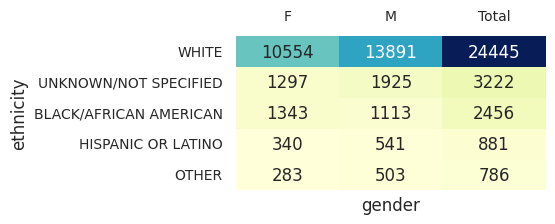

In [ ]:
plt.figure(figsize=(4, 2))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
stats = pd.crosstab(patients.ethnicity, patients.gender, values=patients.subject_id, aggfunc='count', margins="True", margins_name="Total").sort_values("Total", ascending=False).head(6)
sns.heatmap(stats.drop("Total"),cmap="YlGnBu", annot=True, cbar=False,fmt='g')

In [ ]:
pf = patients.copy()
pf['age_group'] = "1. <=30"
pf.loc[pf.age >= 31, 'age_group'] = "2. 31-50"
pf.loc[pf.age >= 51, 'age_group'] = "3. 51-70"
pf.loc[pf.age >= 71, 'age_group'] = "4. >70"


<Axes: xlabel='gender', ylabel='age_group'>

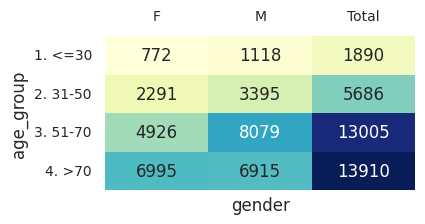

In [ ]:
plt.figure(figsize=(4, 2))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
stats = pd.crosstab(pf.age_group, pf.gender, values=pf.subject_id, aggfunc='count', margins="True", margins_name="Total").sort_index()
sns.heatmap(stats.drop("Total"),cmap="YlGnBu", annot=True, cbar=False,fmt='g')

<Axes: xlabel='gender', ylabel='insurance'>

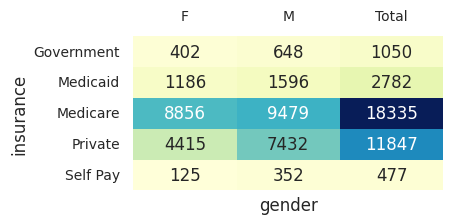

In [ ]:
plt.figure(figsize=(4, 2))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
stats = pd.crosstab(pf.insurance, pf.gender, values=pf.subject_id, aggfunc='count', margins="True", margins_name="Total").sort_index()
sns.heatmap(stats.drop("Total"),cmap="YlGnBu", annot=True, cbar=False,fmt='g')

<Axes: xlabel='gender', ylabel='admission_type'>

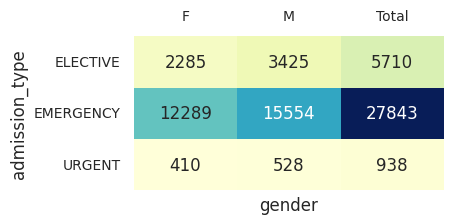

In [ ]:
plt.figure(figsize=(4, 2))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
stats = pd.crosstab(pf.admission_type, pf.gender, values=pf.subject_id, aggfunc='count', margins="True", margins_name="Total").sort_index()
sns.heatmap(stats.drop("Total"),cmap="YlGnBu", annot=True, cbar=False,fmt='g')

<Axes: xlabel='gender', ylabel='first_careunit'>

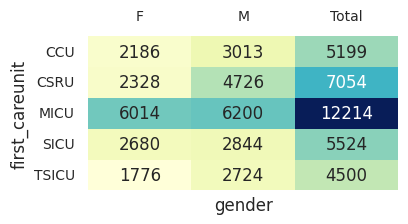

In [ ]:
plt.figure(figsize=(4, 2))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
stats = pd.crosstab(pf.first_careunit, pf.gender, values=pf.subject_id, aggfunc='count', margins="True", margins_name="Total").sort_index()
sns.heatmap(stats.drop("Total"),cmap="YlGnBu", annot=True, cbar=False,fmt='g')

Text(0.5, 1.0, 'cohort age')

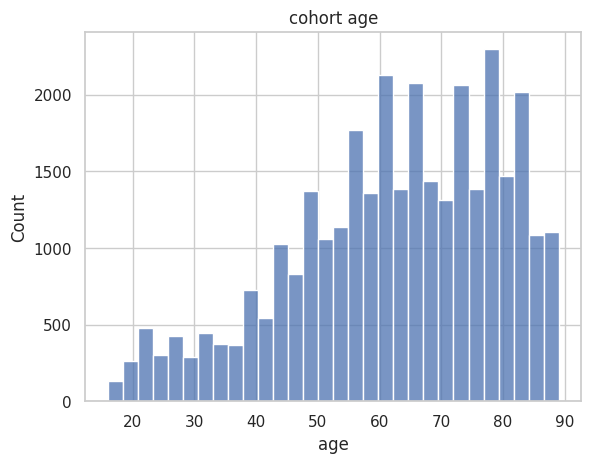

In [ ]:
#patients sample plots
sns.histplot(data=patients[patients['age'] <100], x="age", bins=30).set_title('cohort age')

Text(0.5, 1.0, 'length of stay in icu (hrs)')

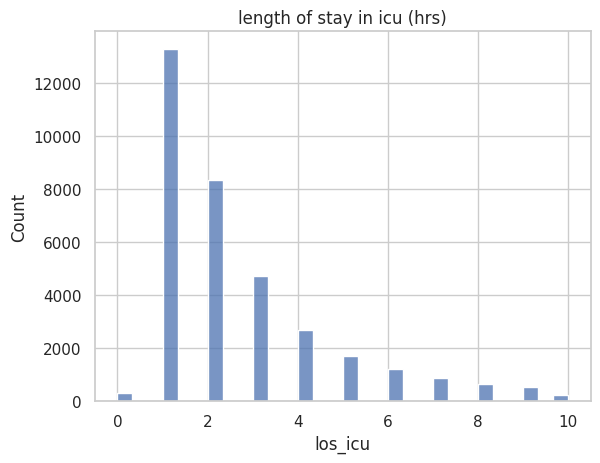

In [ ]:
sns.histplot(data=patients, x="los_icu", bins=30).set_title('length of stay in icu (hrs)')

Text(0.5, 1.0, 'age vs icu LOS')

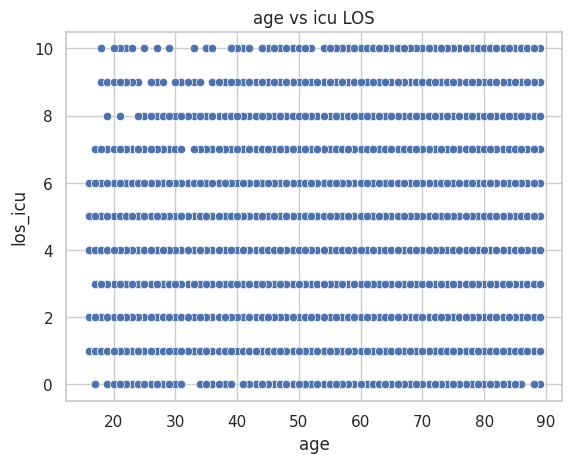

In [ ]:
sns.scatterplot(patients[patients['age'] <100],x='age',y='los_icu').set_title('age vs icu LOS')

Text(0.5, 1.0, 'hosp LOS vs icu LOS')

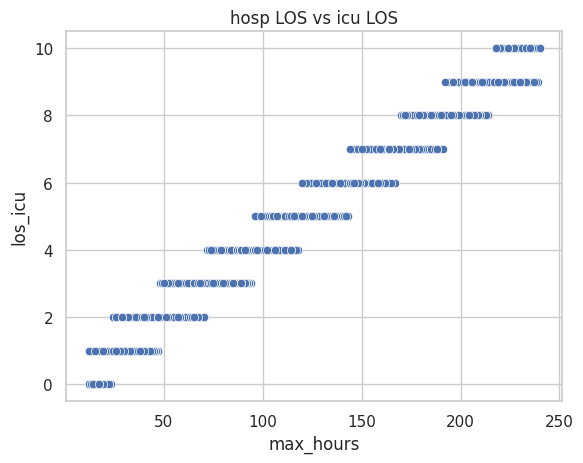

In [ ]:
sns.scatterplot(patients,x='max_hours',y='los_icu').set_title('hosp LOS vs icu LOS')

Text(0.5, 1.0, 'age vs icu mortality')

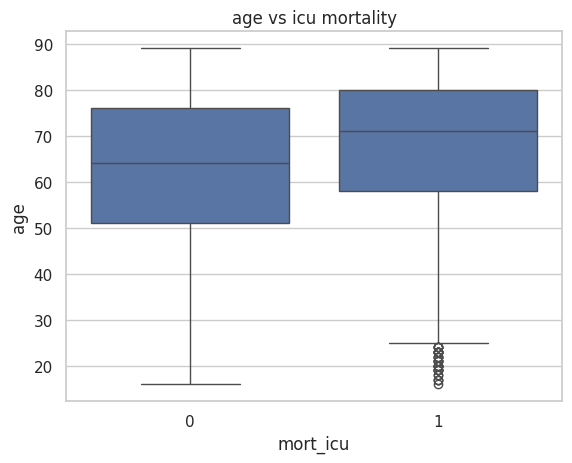

In [ ]:
sns.boxplot(data=patients[patients['age'] <100], y="age", x="mort_icu").set_title('age vs icu mortality')

Text(0.5, 1.0, 'age vs hospital mortality')

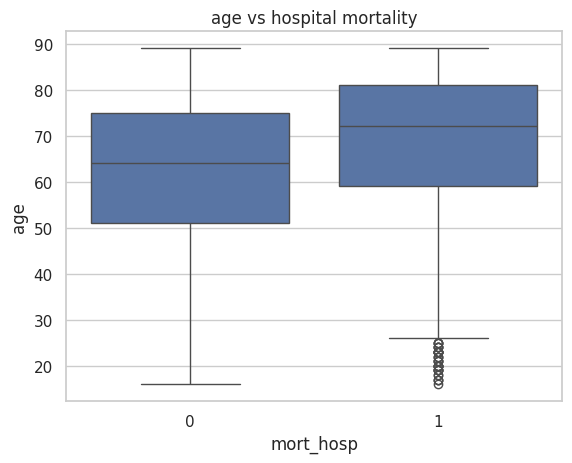

In [ ]:
sns.boxplot(data=patients[patients['age'] <100], y="age", x="mort_hosp").set_title('age vs hospital mortality')

<Axes: xlabel='mort_icu', ylabel='los_icu'>

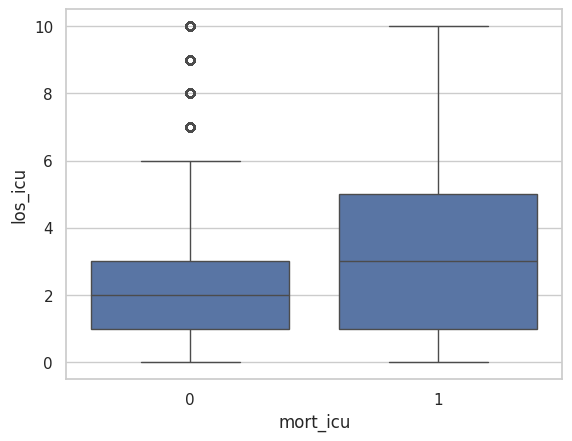

In [ ]:
sns.boxplot(data=patients, y="los_icu", x="mort_icu")

In [ ]:
vital_labs.shape
vital_labs.head(5)

LEVEL2                                 alanine aminotransferase           \
aggs                                                      count mean std   
subject_id hadm_id icustay_id hours_in                                     
10006      142345  206504     0                             1.0  9.0 NaN   
                              1                             0.0  NaN NaN   
                              2                             0.0  NaN NaN   
                              3                             0.0  NaN NaN   
                              4                             0.0  NaN NaN   

LEVEL2                                 albumin          albumin ascites       \
aggs                                     count mean std           count mean   
subject_id hadm_id icustay_id hours_in                                         
10006      142345  206504     0            1.0  3.4 NaN             0.0  NaN   
                              1            0.0  NaN NaN             0.0  NaN   
                              2            0.0  NaN NaN             0.0  NaN   
                              3            0.0  NaN NaN             0.0  NaN   
                              4            0.0  NaN NaN             0.0  NaN   

LEVEL2                                     alkaline phosphate  ...  \
aggs                                   std              count  ...   
subject_id hadm_id icustay_id hours_in                         ...   
10006      142345  206504     0        NaN                1.0  ...   
                              1        NaN                0.0  ...   
                              2        NaN                0.0  ...   
                              3        NaN                0.0  ...   
                              4        NaN                0.0  ...   

LEVEL2                                 venous pvo2 weight           \
aggs                                           std  count mean std   
subject_id hadm_id icustay_id hours_in                               
10006      142345  206504     0                NaN    0.0  NaN NaN   
                              1                NaN    0.0  NaN NaN   
                              2                NaN    0.0  NaN NaN   
                              3                NaN    0.0  NaN NaN   
                              4                NaN    0.0  NaN NaN   

LEVEL2                                 white blood cell count           \
aggs                                                    count mean std   
subject_id hadm_id icustay_id hours_in                                   
10006      142345  206504     0                           1.0  7.8 NaN   
                              1                           0.0  NaN NaN   
                              2                           0.0  NaN NaN   
                              3                           0.0  NaN NaN   
                              4                           0.0  NaN NaN   

LEVEL2                                 white blood cell count urine           
aggs                                                          count mean std  
subject_id hadm_id icustay_id hours_in                                        
10006      142345  206504     0                                 0.0  NaN NaN  
                              1                                 0.0  NaN NaN  
                              2                                 0.0  NaN NaN  
                              3                                 0.0  NaN NaN  
                              4                                 0.0  NaN NaN  

[5 rows x 297 columns]

In [ ]:
# vital labs means dataframe

#loading full dataset results that were produced locally due to time limitation
vital_labs_mean = pd.read_csv(vital_labs_mean_file_full, index_col=None, compression="gzip")
vital_labs_mean.shape


(3775283, 108)

In [ ]:
vital_labs_mean.head(5)

,subject_id,hadm_id,icustay_id,hours_in,alanine aminotransferase,albumin,albumin ascites,albumin pleural,albumin urine,alkaline phosphate,...,tidal volume set,tidal volume spontaneous,total protein,total protein urine,troponin-i,troponin-t,venous pvo2,weight,white blood cell count,white blood cell count urine
0,3,145834,211552,0,25.0,1.8,NaN,NaN,NaN,73.0,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.842857,NaN
1,3,145834,211552,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,145834,211552,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,145834,211552,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,145834,211552,4,NaN,NaN,NaN,NaN,NaN,NaN,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='heart rate', ylabel='Count'>

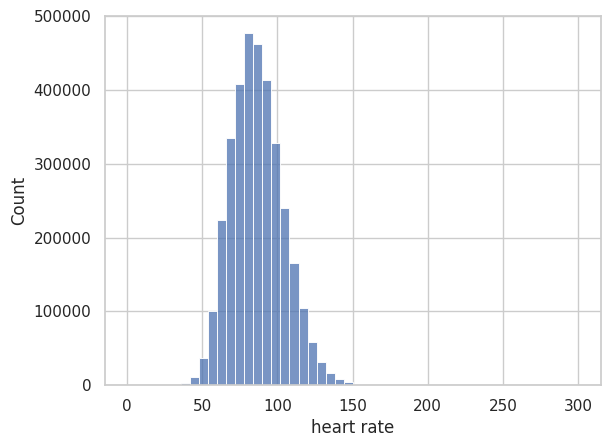

In [ ]:
# sample histograms of some vitals and labs

sns.histplot(data=vital_labs_mean['heart rate'].dropna(),  bins=50)


<Axes: xlabel='systolic blood pressure', ylabel='Count'>

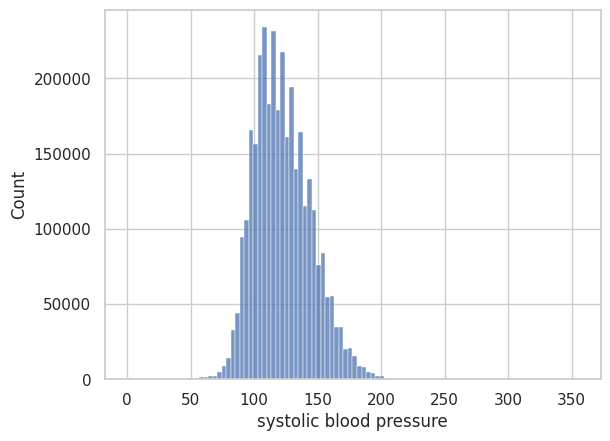

In [ ]:
sns.histplot(data=vital_labs_mean['systolic blood pressure'].dropna(),  bins=100)

<Axes: xlabel='respiratory rate', ylabel='Count'>

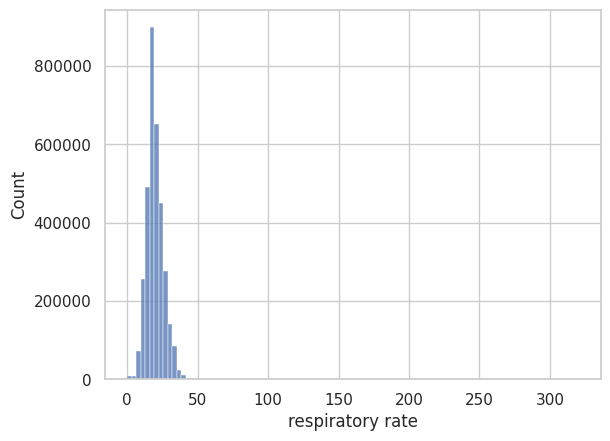

In [ ]:
sns.histplot(data=vital_labs_mean['respiratory rate'].dropna(),  bins=100)

<Axes: xlabel='tidal volume observed', ylabel='Count'>

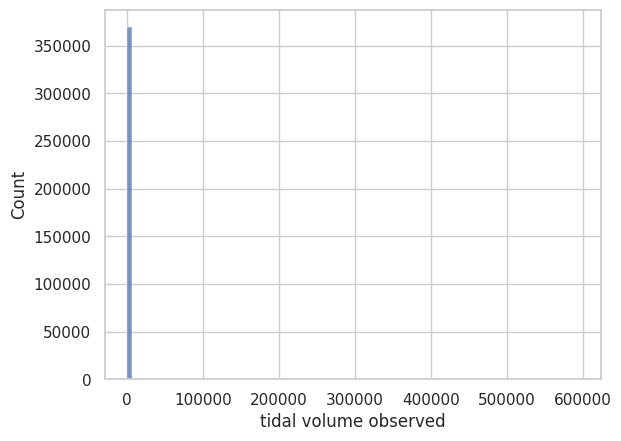

In [ ]:
sns.histplot(data=vital_labs_mean['tidal volume observed'].dropna(),  bins=100)

<Axes: xlabel='temperature', ylabel='Count'>

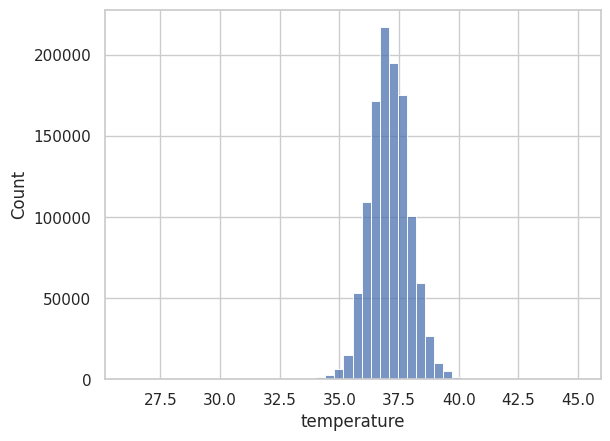

In [ ]:
sns.histplot(data=vital_labs_mean['temperature'].dropna(),  bins=50)

<Axes: xlabel='sodium', ylabel='Count'>

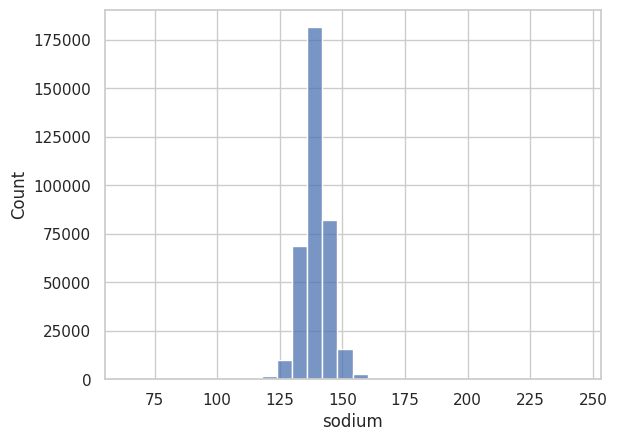

In [ ]:
sns.histplot(data=vital_labs_mean['sodium'].dropna(),  bins=30)

In [ ]:
# interventions dataframe
interventions_df.head(5)

,subject_id,hadm_id,icustay_id,hours_in,vent,vaso,dobutamine,dopamine,epinephrine,milrinone,norepinephrine,phenylephrine,vasopressin,colloid_bolus,crystalloid_bolus
0,10098,180685,262670,0,1,0,0,0,0,0,0,0,0,0,0
1,10098,180685,262670,1,1,0,0,0,0,0,0,0,0,0,0
2,10098,180685,262670,2,1,0,0,0,0,0,0,0,0,0,0
3,10098,180685,262670,3,1,0,0,0,0,0,0,0,0,0,0
4,10098,180685,262670,4,1,0,0,0,0,0,0,0,0,0,0


Example output from the pipeline for one patient is given below showing both static and time series data.

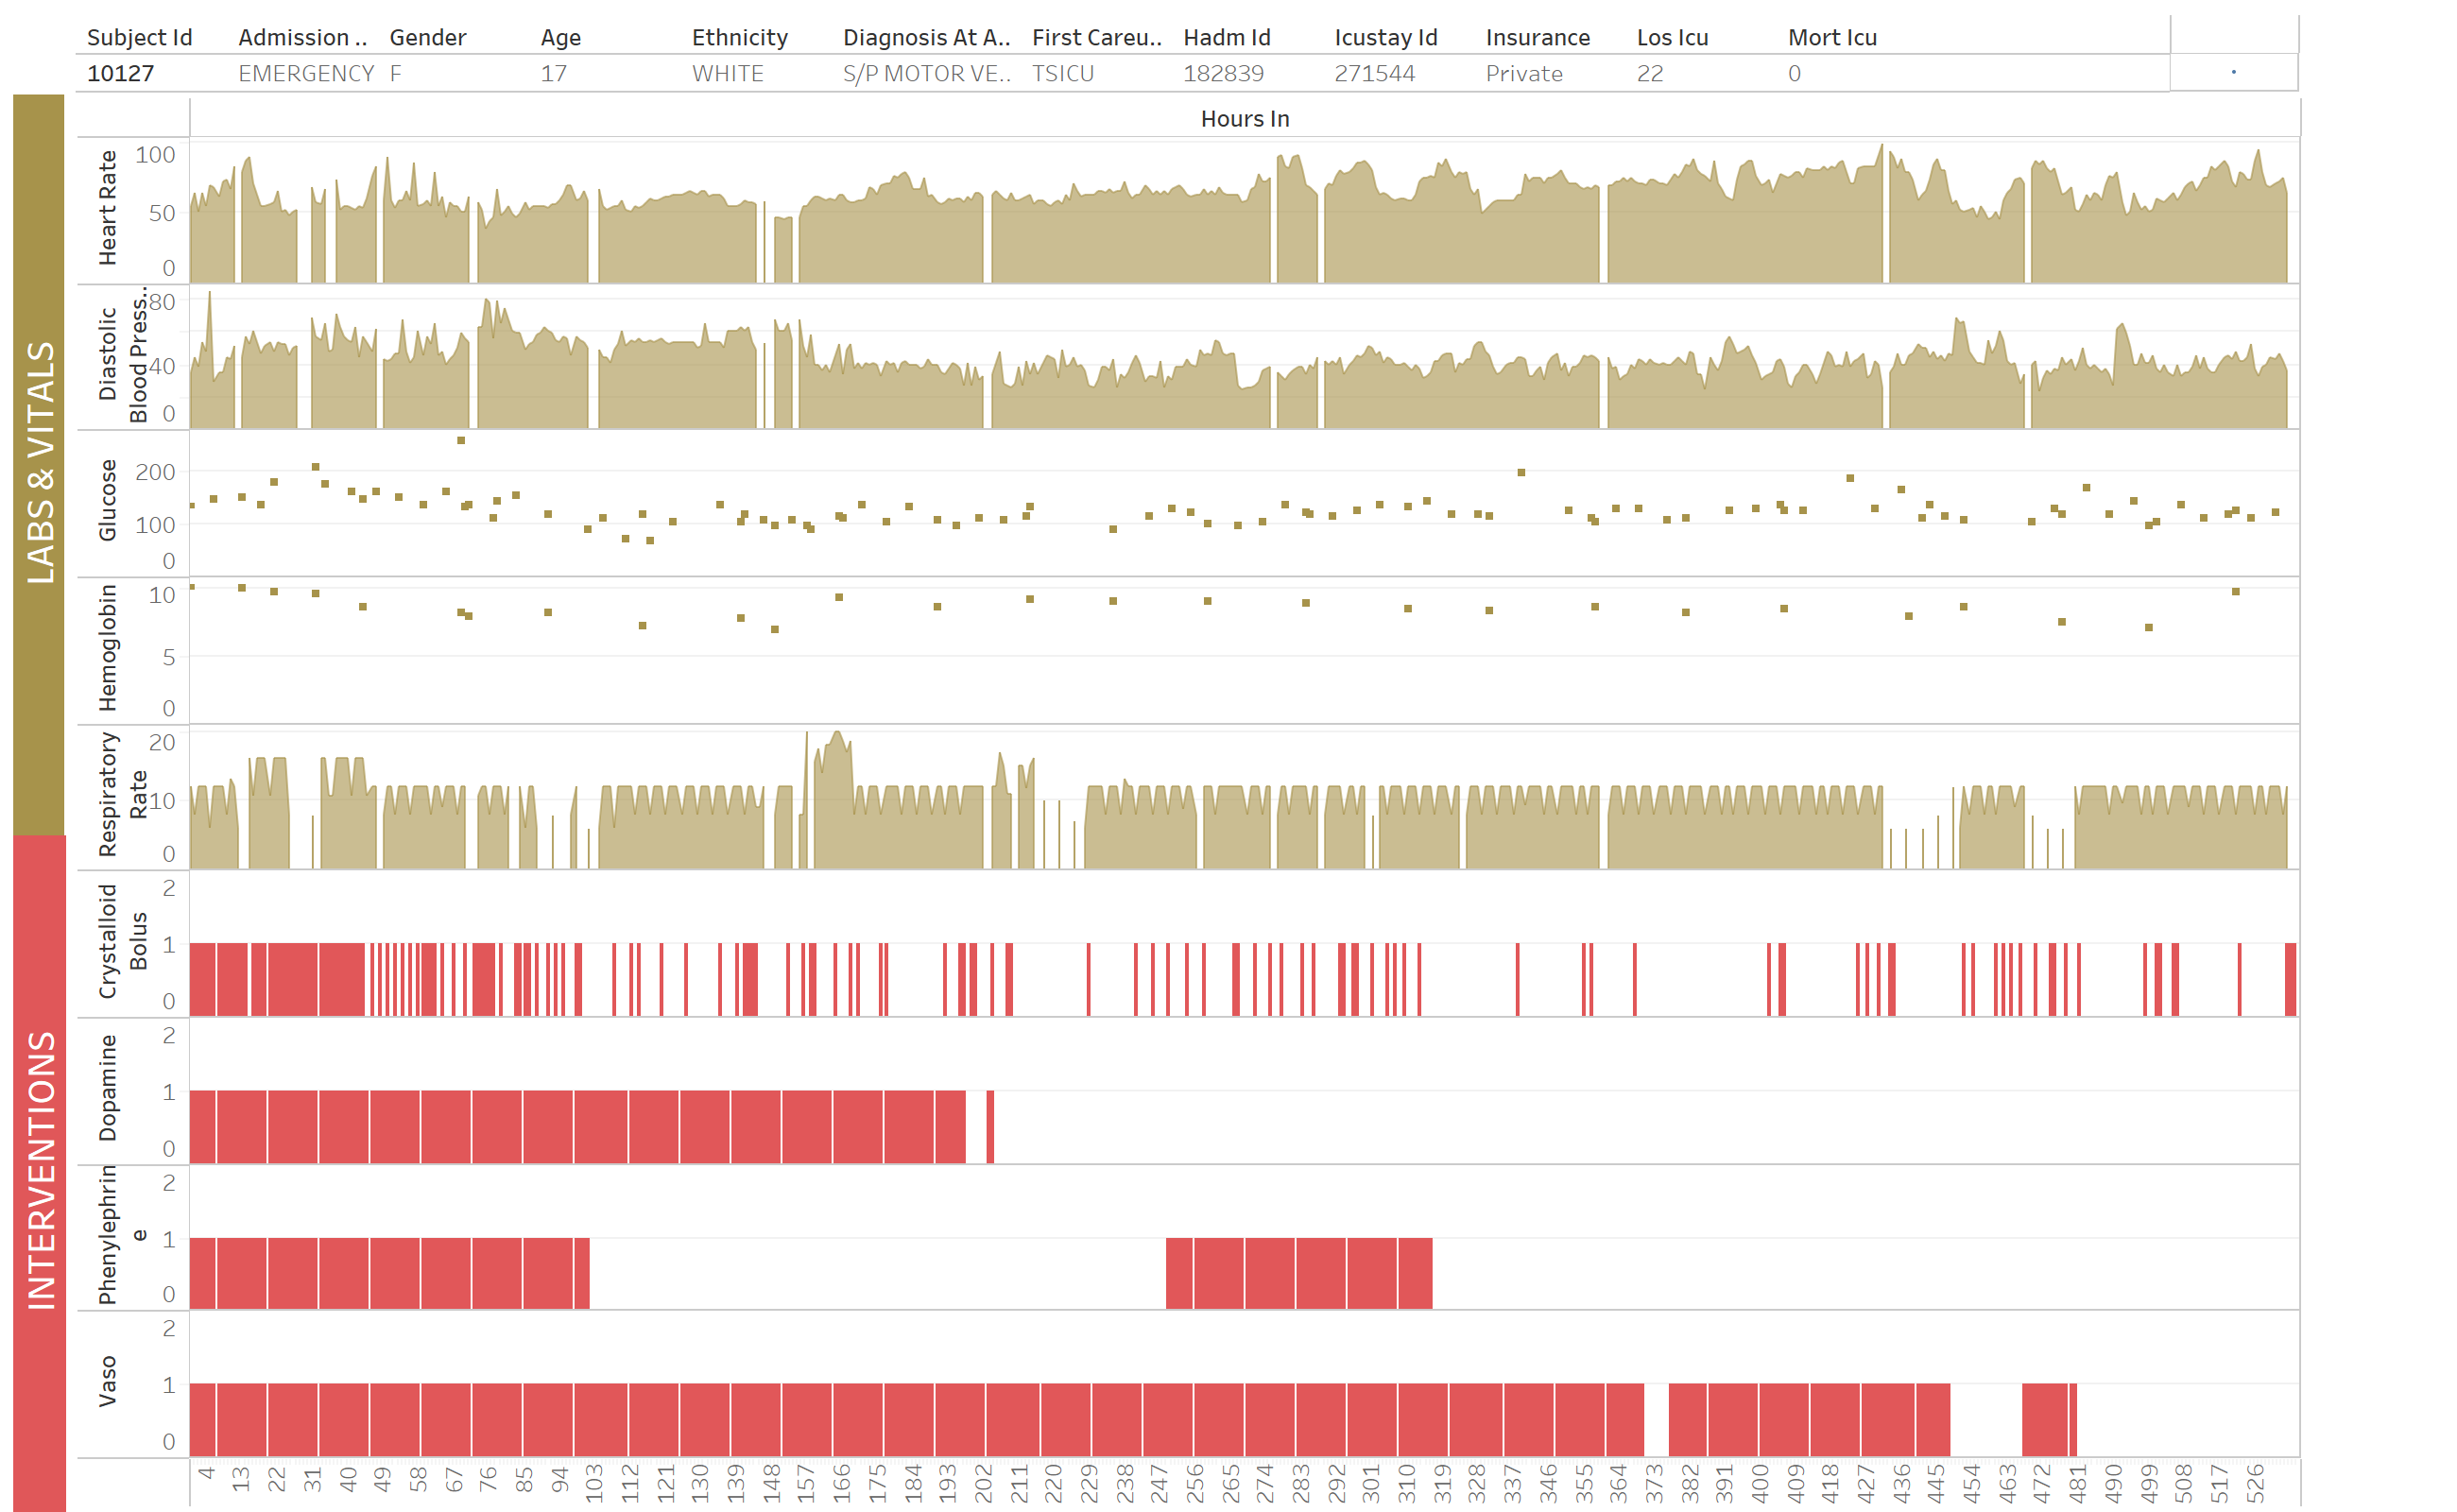

# Discussion

***Reproducibility***

*   We have been able to fully reproduce the patients, vital_labs, vital_labs_mean and interventions dataframes according to the original paper.
*   The extraction pipeline is producing desired results when executed on both demo and full datasets.
*   For comparison, results have been produced with default cohort selection criteria as used by the orginal paper and results are found to be matching the original paper as shown in details in the results section.
*   We were not able to train any ML models to demonstrate the utility of the pipeline because of compute resource limitation but that was not the main objective of the paper, so we still consider the paper to be 100% reproducible.

***Ease of reproduction***

*   Original code utilized PostgreSql on a local machine, posing cost barriers for independent researchers due to resource constraints.

*   Transition to Google BigQuery facilitated easier reproduction of the code, leveraging cloud accessibility for improved accessibility and scalability.


***Suggestions for authors/other reproducers***

*   Use the datasets hosted on cloud instead of creating databases on local machines.
*   Newer dataset MIMIC-IV has been made available with more detailed records, so the pipeline can be updated or a new similar pipleine can be created to work with the newer dataset.






# References

[1]. S. Wang, M. B. A. McDermott, G. Chauhan, M. Ghassemi, M. C. Hughes, and T. Naumann (2020). MIMIC-Extract: A Data Extraction, Preprocessing, and Representation Pipeline for MIMIC-III. ACM CHIL ’20, April 2–4, 2020, Toronto, ON, Canada. https://arxiv.org/abs/1907.08322

[2]. Physionet (2016). MIMIC-III Clinical Database, https://physionet.org/content/mimiciii/1.4/

[3]. MIT Laboratory for Computational Physiology (2024). mimic-code, https://github.com/MIT-LCP/mimic-code/tree/main/mimic-iii/concepts

[4]. Johnson A. E. W., Stone D. J., Celi L. A., Pollard T. J. (2018). The MIMIC Code Repository: enabling reproducibility in critical care research https://doi.org/10.1093/jamia/ocx084

[5]. MIT Laboratory for Computational Physiology (2021). BigQuery, https://mimic.mit.edu/docs/iii/tutorials/intro-to-mimic-iii-bq/